# A simple CNN for the edge lover task
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_course_2024/refs/heads/main/notebooks/art_lover.png" alt="Sample Image" width="150">

**Storytime:** There is an artlover who only likes images with vertical stripes. The goal of this notebook is to use an algorithm (CNN) which helps to classify if the art lover likes the image or not.




**Task:**
You train a very simple CNN with only 1 kernel to distinguish between images containing vertical and images containing horizontal stripes. To check what pattern is recognized by the learned kernel you will visualize the weights of the kernel as an image. You will see that the CNN learns a useful kernel (either a vertical or horiziontal bar). You can experiment with the code to check the influence of the kernel size, the activation function and the pooling method on the result.  


**Dataset:** You work with an artficially generated dataset of greyscale images (50x50 pixel) with 10 vertical or horizontal bars. We want to classify them into whether the art lover, who only loves vertical strips, will like the image (y = 0) or not like the image (y = 1).  

The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.  

### a)  Generation of the data
Write a function which creates an artficially dataset of black and white images (50x50 pixel) with 10 vertical or horizontal bars (10 pixel long). Use this function to create a training dataset of 1000 examples with 500 vertical and 500 horizontal examples. Similarily create a validation dataset of 1000 examples. Normalize the pixel values to be between 0 and 1.
You should get the following output:
```{python}
print(X_train.shape) #(1000, 50, 50, 1)
print(np.unique(Y_train)) #[0 1]
```

### b) Build the simplest possible CNN
Make a CNN with one convolution 5x5 and 1 output. Train the CNN on the data from a). You should have no more than 28 trainable parameters (see `model.summary()`) in the network. 
* Plot the learning curves: (epochs vs training loss and validation loss) and epochs vs accuracy.You should get an accuracy of approximatly 1.

Hint: Use the max-pooling operation in a clever way.


### c) Visualize the learned kernel
Visualize the learned kernel, you might want to use `model.get_weights()`. Does the learned kernel makes sense?

a)

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [149]:

def create_bar_dataset(n):
    img_size = 50
    n_bars = 10
    bar_length = 10
    X = np.zeros((n, img_size, img_size, 1))
    Y = np.zeros(n, dtype=int)

    n_vertical = n // 2

    for i in range(n_vertical):
        img = np.zeros((img_size, img_size))
        for _ in range(n_bars):
            x = np.random.randint(0, img_size)
            y = np.random.randint(0, img_size - bar_length + 1)
            img[y:y+bar_length, x] = 1.0
        X[i, :, :, 0] = img
        Y[i] = 0

    for i in range(n - n_vertical):
        img = np.zeros((img_size, img_size))
        for _ in range(n_bars):
            x = np.random.randint(0, img_size - bar_length + 1)
            y = np.random.randint(0, img_size)
            img[y, x:x+bar_length] = 1.0
        X[n_vertical + i, :, :, 0] = img
        Y[n_vertical + i] = 1

    indices = np.random.permutation(n)
    return X[indices], Y[indices]

In [150]:
X_train, Y_train = create_bar_dataset(1000)
X_val, Y_val = create_bar_dataset(1000)

print(X_train.shape)
print(np.unique(Y_train))

(1000, 50, 50, 1)
[0 1]


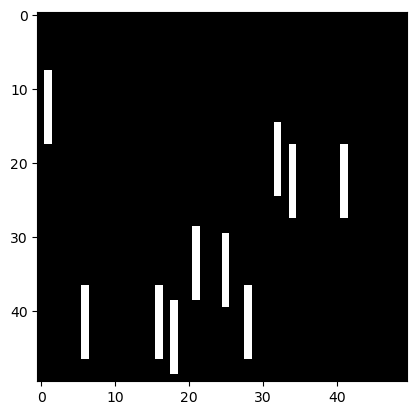

In [151]:
plt.imshow(X_train[0, :, :, 0], cmap='gray')
plt.show()

### b) Build the simplest possible CNN
Make a CNN with one convolution 5x5 and 1 output. Train the CNN on the data from a). You should have no more than 28 trainable parameters (see `model.summary()`) in the network. 
* Plot the learning curves: (epochs vs training loss and validation loss) and epochs vs accuracy.You should get an accuracy of approximatly 1.

Hint: Use the max-pooling operation in a clever way.

In [152]:
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 5)
        self.pool = nn.MaxPool2d(46, 46)
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = F.sigmoid(self.fc(x))
        return x

net = cnn()


In [153]:
summary(net, (1, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 46, 46]              26
         MaxPool2d-2              [-1, 1, 1, 1]               0
            Linear-3                    [-1, 1]               2
Total params: 28
Trainable params: 28
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [154]:
batch_size = 32

X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
Y_val = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1)

trainset = torch.utils.data.TensorDataset(X_train, Y_train)
valset = torch.utils.data.TensorDataset(X_val, Y_val)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)


In [155]:

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(50):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(trainloader))
    train_accs.append(correct / total)
    
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(valloader))
    val_accs.append(correct / total)

print('Finished Training')

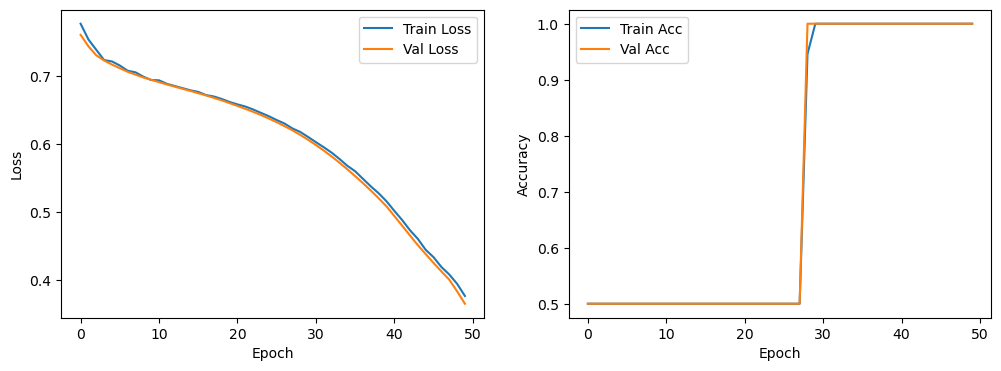

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

### c) Visualize the learned kernel
Visualize the learned kernel, you might want to use `model.get_weights()`. Does the learned kernel makes sense?

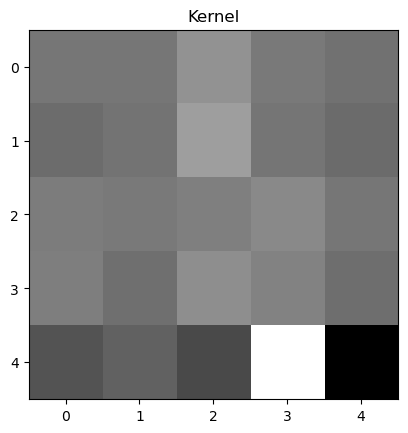

In [ ]:
kernel = net.conv1.weight.data.numpy()[0, 0]
plt.imshow(kernel, cmap='gray')
plt.title('Kernel')
plt.show()